# Climate Change India NLP
The primary goal of this script is to analyze the sentiment of climate change news articles published in India from 2013- 2016. To do this, I will first use a data set from Jogesh 2012, that has manually coded sentiments to train my model. I will then fit this model to the new data.

1. Data clean up
2. Use weblinks to get newsarticle content and text using the newspaper library
3. Use NLP to clean the text data 
4. Use machine learning to associate words to sentiments in training data
5. Apply this to test data 

In [38]:
#The data weblinks first need to extracted from excel files which I did in R -- 
#no idea how to read excel files in python!. 

import pandas as pd
df = pd.read_csv('cleanURLData.csv')
df.columns = ['num','num2','url','codes']

#Write a function to replace codes with sentiments

#make the separators consistant + to , and remove spaces
df['codes'] = df['codes'].replace(['\+'],', ', regex=True)
df['codes'] = df['codes'].replace([' '],'', regex=True)

#split comma separated codes into individual categories
splitcodes=df['codes'].str.split(',', expand=True)


#create new df 
sentiment = splitcodes

#change codes to real sentiments 
#obj =splitcodes[0].replace(['^S'], 'Science', regex=True)
sentiment=splitcodes.replace(['^S'], 'Science', regex=True)
sentiment=sentiment.replace(['^GP'], 'GlobalPolitics', regex=True)
sentiment=sentiment.replace(['^IS'], 'IndianScience', regex=True)
sentiment=sentiment.replace(['^IP'], 'IndianPolitics', regex=True)
sentiment=sentiment.replace(['^BZ'], 'Buisness', regex=True)
sentiment=sentiment.replace(['^TD'], 'Trends', regex=True)

#append sentiment to main df
df['sentiment']=sentiment[0]
df['ind'] = df.index


#replacing all the other unassigned values for sentiment with NONE
newsent=[]
for x in df['sentiment']:
    if x != 'Science' and x !='GlobalPolitics' and x !='IndianScience' and x !='IndianPolitics' and x !='Buisness'  :
        newsent.append(None)
    else:
        newsent.append(x)
        
newSentiment= pd.DataFrame(newsent)
newSentiment['ind'] = newSentiment.index
newSentiment.columns = ['new_sentiment','ind']
print(df.head())
print(newSentiment.head())


   num  num2                                                url       codes  \
0    1   NaN  http://www.indianexpress.com/news/the-green-co...         NaN   
1    2   2.0  http://www.indianexpress.com/news/china-and-in...  S,A6,D1,T1   
2    3   3.0  http://www.financialexpress.com/news/climate-t...     S,A1,T7   
3    4   4.0  http://www.livemint.com/2009/08/31211415/Tech-...    GP,A6,T2   
4    5   5.0  http://lite.epaper.timesofindia.com/getpage.as...  S,A6,D1,T6   

        sentiment  ind  
0             NaN    0  
1         Science    1  
2         Science    2  
3  GlobalPolitics    3  
4         Science    4  
    new_sentiment  ind
0            None    0
1         Science    1
2         Science    2
3  GlobalPolitics    3
4         Science    4


## Extract Newspaper data from html links


In [39]:
from newspaper import Article	
import requests


def html_to_text( urls, ind ):
    ###for newspaper articles, this extracts the content from the html links using the Newspaper
    ###library http://newspaper.readthedocs.io/en/latest/
    request = requests.get(urls)
    if request.status_code == 200:
        a = Article(urls)  
        a.download()
        a.parse()
        #a.nlp() #takes to long and not nessesary for now
        text = a.text
        title = a.title
        authors = a.authors
        date = a.publish_date
        sourceurl = a.source_url
        #keywords = a.keywords
        data =(ind,text,title,sourceurl,authors,date)
    else:
        data =('NA','NA','NA','NA','NA')
    return(data)

#testing the function on the first link    
data =html_to_text(df['url'][0],0)
print(data)


(0, u'Few creatures would seem as beneficent as the cow. Properly grazed and groomed, it gives us burgers and milk, boot leather and fertiliser. Lately, however, radical green groups and celebrity vegans like Paul McCartney have made cows out to be weapons of mass destruction: not only has their meat caused an epidemic of hypertension and heart disease, but they also trample rainforests, trash the soil, and foul the air with greenhouse gases.\n\nScientists say that every year, the average Holstein produces up to 180 kg of methane, which traps 25 times more heat than does carbon dioxide. All told, bringing meat from the pasture to the griddle produces 18 per cent of global greenhouse-gas emissions, according to the United Nations. Last year, Rajendra Pachauri, the chair of the UN\'s Intergovernmental Panel on Climate Change, called upon everyone to give up eating meat at least one day a week, giving birth to the global meatless Monday. "If anyone wants to save the planet, all they have 

In [40]:
import os
import pickle

if os.path.exists("news_pickle.p"):
    print("News Data already downloaded")
    newsdf = pickle.load(open("news_pickle.p", "rb"))
else:
    Alldata =[]
    Narticles = df["url"].size
    print "Extracting data from online news weblinks...\n"
    for i in xrange(0, Narticles):
        try:
            Alldata.append(html_to_text(df['url'][i],i))
            if( (i+1)%100 == 0 ):
                print "Downloading %d of %d\n" % ( i+1, Narticles )
        except:
            pass
        #will return a list of tuples with all the data. 
        
    newsdf = pd.DataFrame(eval('Alldata')) #not sure i understand why i use eval
    newsdf.columns = ['ind','text', 'title','source','author','date']

    #merges text with original file to asssociate the sentiment
    newsdf =pd.merge(newsdf, df, left_on='ind', right_on='ind', how='inner')
    pickle.dump(newsdf, open("news_pickle.p", "wb"))
    #print(newsdf.columns.values)

print("Number of articles: "+str(len(newsdf)))
#adding the cleaned up sentiment
newsdf =pd.merge(newsdf, newSentiment, left_on='ind', right_on='ind', how='inner')
print(newsdf.head())

News Data already downloaded
Number of articles: 1342
  ind                                               text  \
0   0  Few creatures would seem as beneficent as the ...   
1   1  You can see their point. China and India accou...   
2   2  Only a squawk from a sandhill crane broke the ...   
3   3  Updated: Mon, Aug 31 2009. 10 36 PM IST\n\nWe ...   
4   5  The the highest concentration of solar home pa...   

                                             title  \
0                                   Indian Express   
1                         China and India will pay   
2  Climate trouble may be bubbling up in far North   
3                     Tech support for the climate   
4           Where the sun shines on climate change   

                             source               author                 date  \
0      http://www.indianexpress.com                   []                 None   
1      http://www.indianexpress.com                   []                 None   
2   http://www.fi

## Extract meaningful words from news articles


In [41]:
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()


def text_to_words( rawtext ):
    # Function to convert a raw review to a string of words
    # The input is a single string, and 
    # the output is a single string
    #
    # 1. Remove HTML
    news_text = BeautifulSoup(rawtext).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", news_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))
    # add additonal words that are prominent but not meaningful
    added_stop_words =["one","would","also","subscription","subscribe","newsletter","click","thank","email","sent","link","said","use"]
    stops |= set(added_stop_words)
    #
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    stemmed_words =[]
    for w in meaningful_words: 
        stemmed_words.append(porter_stemmer.stem(w))   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( stemmed_words ))  

#test function
clean_text = text_to_words( newsdf['text'][0] )
print(clean_text)


creatur seem benefic cow properli graze groom give us burger milk boot leather fertilis late howev radic green group celebr vegan like paul mccartney made cow weapon mass destruct meat caus epidem hypertens heart diseas trampl rainforest trash soil foul air greenhous gase scientist say everi year averag holstein produc kg methan trap time heat carbon dioxid told bring meat pastur griddl produc per cent global greenhous ga emiss accord unit nation last year rajendra pachauri chair un intergovernment panel climat chang call upon everyon give eat meat least day week give birth global meatless monday anyon want save planet stop eat meat mccartney famous perhap sinc worldwid product meat quadrupl million tonn year even everyon rich nation swore meat today consumpt continu soar driven protein hungri rise middl class china brazil develop nation reason seriou environment planner recent focus elimin meat industri turn green tall order make beef pork chicken environment devast process fell fores

In [42]:
#  the number of articles
num_articles = newsdf['text'].size
print("Extracting words from "+ str(num_articles)+" articles")

# Initialize an empty list to hold the clean text
clean_news_text = []

# Loop over each article text; create an index i that goes from 0 to the length
# of the list 
for i in xrange( 0, num_articles ):
    # Call the function for each one, and add the result to the list of
    # clean reviews
     # If the index is evenly divisible by 1000, print a message
    if( (i+1)%100 == 0 ):
        print "Article %d of %d\n" % ( i+1, num_articles )  
    clean_news_text.append( text_to_words( newsdf["text"][i] ) )
    
print("Extracted "+ str(len(clean_news_text))+" articles")

Extracting words from 1342 articles
Article 100 of 1342

Article 200 of 1342

Article 300 of 1342

Article 400 of 1342

Article 500 of 1342

Article 600 of 1342

Article 700 of 1342

Article 800 of 1342

Article 900 of 1342

Article 1000 of 1342

Article 1100 of 1342

Article 1200 of 1342

Article 1300 of 1342

Extracted 1342 articles


## Use Bag of words to get a numerical representation of words



In [43]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  The initializer pretty much just defines the parameters 
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000) 

#setting the max to 5000 words and I can change this

# fit_transform does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_news_text) # this gives a sklearn matrix 

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray() # this is an array of words and their instances

# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
vocab_frame = pd.DataFrame({'words': vocab}) # just converts the list to a dataframe with colum name 'words'

import numpy as np

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0) # summing up the instances of each word in the array

# For each, print the vocabulary word and the number of times it 
# appears in the training set

#for tag, count in zip(vocab, dist): #zip makes a tuple and tag and count iterate over this tuple. 
#    print(count, tag)
    
    

## K-means clustering 

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=20000,
                                 min_df=0.10, stop_words=None,
                                 tokenizer=None)

tfidf_matrix = tfidf_vectorizer.fit_transform(clean_news_text) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

print(terms)

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)


(1342, 340)
[u'accept', u'accord', u'account', u'achiev', u'across', u'act', u'action', u'activ', u'ad', u'adapt', u'address', u'adopt', u'africa', u'agre', u'agreement', u'ahead', u'allow', u'alreadi', u'among', u'announc', u'anoth', u'approach', u'area', u'around', u'ask', u'atmospher', u'attempt', u'away', u'back', u'base', u'basic', u'becom', u'big', u'billion', u'bind', u'brazil', u'bring', u'build', u'busi', u'call', u'cannot', u'capac', u'capita', u'carbon', u'case', u'caus', u'cent', u'centr', u'challeng', u'chang', u'china', u'clean', u'clear', u'climat', u'close', u'co', u'come', u'comment', u'commit', u'commun', u'compani', u'complet', u'concern', u'confer', u'consid', u'continu', u'contribut', u'convent', u'copenhagen', u'cost', u'could', u'countri', u'creat', u'critic', u'current', u'cut', u'date', u'day', u'deal', u'decemb', u'decis', u'delhi', u'demand', u'develop', u'differ', u'dioxid', u'director', u'discuss', u'domest', u'done', u'due', u'earlier', u'econom', u'econom

In [45]:
from sklearn.cluster import KMeans
num_clusters = 5
#splits articles into 5 clusters
km = KMeans(n_clusters=num_clusters)
#based on the distance matrix of words
km.fit(tfidf_matrix)
#turns cluster membership to a list
clusters = km.labels_.tolist()
print(clusters[:10])

#make a series so that we can add it to the main df
clus = pd.Series(clusters)
#Then add the cluster values to the DataFrame:
newsdf['cluster'] = clus.values
print(newsdf['cluster'].value_counts())

print("Top terms per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 


[2, 4, 1, 1, 2, 2, 4, 4, 4, 4]
4    493
1    397
2    251
0    181
3     20
Name: cluster, dtype: int64
Top terms per cluster:


In [46]:
for i in range(num_clusters):
    print("Cluster %d :" % i)
    
    for ind in order_centroids[i, :20]: #replace 6 with n words per cluster
        print(' %s' % terms[ind].split(' '))



Cluster 0 :
 [u'subscrib']
 [u'complet']
 [u'process']
 [u'ga']
 [u'futur']
 [u'exist']
 [u'expect']
 [u'face']
 [u'fact']
 [u'far']
 [u'final']
 [u'financ']
 [u'financi']
 [u'everi']
 [u'first']
 [u'five']
 [u'follow']
 [u'forest']
 [u'framework']
 [u'fuel']
Cluster 1 :
 [u'climat']
 [u'chang']
 [u'report']
 [u'year']
 [u'scientist']
 [u'forest']
 [u'warm']
 [u'global']
 [u'research']
 [u'peopl']
 [u'govern']
 [u'india']
 [u'water']
 [u'studi']
 [u'temperatur']
 [u'scienc']
 [u'world']
 [u'time']
 [u'say']
 [u'minist']
Cluster 2 :
 [u'energi']
 [u'carbon']
 [u'solar']
 [u'power']
 [u'india']
 [u'emiss']
 [u'project']
 [u'effici']
 [u'per']
 [u'technolog']
 [u'compani']
 [u'climat']
 [u'develop']
 [u'chang']
 [u'intens']
 [u'industri']
 [u'gener']
 [u'renew']
 [u'govern']
 [u'countri']
Cluster 3 :
 [u'use']
 [u'support']
 [u'yet']
 [u'find']
 [u'expect']
 [u'face']
 [u'fact']
 [u'far']
 [u'final']
 [u'financ']
 [u'financi']
 [u'first']
 [u'everi']
 [u'five']
 [u'follow']
 [u'forest']
 

## Is cluster membership representative of sentiment? 

In [47]:
sentiment_cluster = pd.crosstab(index=newsdf["new_sentiment"], 
                           columns=newsdf["cluster"])

print(sentiment_cluster)

cluster           0    1   2   3    4
new_sentiment                        
Buisness         13   54  68   1    5
GlobalPolitics  106  152  71  13  423
IndianPolitics   43   96  94   4   53
IndianScience     2   28   4   0    0
Science          13   50   7   2    3


## Graph of clusters by year (need to fix -- most articles don't have date of publication)

In [52]:
#create separate year/month columns

import datetime
year=[]
month=[]
for date in newsdf['date']:
    try:
        d = datetime.datetime.strptime(str(date), "%Y-%m-%d %H:%M:%S")
        year.append(d.year)
        month.append(d.month)
    except:
        year.append(None)
        month.append(None)
        pass
newsdf['month'] =pd.DataFrame(month) 
newsdf['year'] =pd.DataFrame(year) 


cluster        0   1   2   4
year   month                
2009.0 1.0     0   0   1   0
       6.0     1   0   0   0
       8.0     0   1   0   0
       9.0    19   4  10  16
       10.0   31  14   4  18
       11.0   35   9  20  17
       12.0   79  22   9  41
2010.0 1.0     1  37  18  13
       2.0     9   2   2   2
       3.0     6   7   4   4


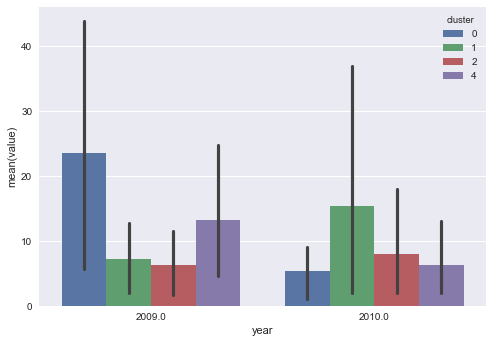

In [66]:
#plot graphs by cluster
import seaborn as sns
year_month_cluster = pd.crosstab(index=[newsdf["year"],newsdf["month"]], 
                           columns=newsdf["cluster"])
print(year_month_cluster)
# now stack and reset
stacked = year_month_cluster.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=(stacked.year), y=stacked.value, hue=stacked.cluster)



new_sentiment  Buisness  GlobalPolitics  IndianPolitics  IndianScience  \
year   month                                                             
2009.0 1.0            1               0               0              0   
       6.0            0               1               0              0   
       8.0            0               1               0              0   
       9.0            6              32               6              0   
       10.0           3              33              21              3   
       11.0           6              42              22              3   
       12.0          11              98              28              0   
2010.0 1.0           12              37              12              6   
       2.0            1               7               6              0   
       3.0            3               9               3              1   

new_sentiment  Science  
year   month            
2009.0 1.0           0  
       6.0           0  
       8.0 

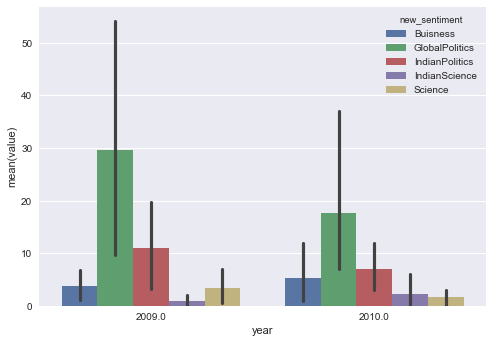

In [65]:
#plot graphs by sentiment
year_month_sentiment = pd.crosstab(index=[newsdf["year"],newsdf["month"]], 
                           columns=newsdf["new_sentiment"])
print(year_month_sentiment)
# now stack and reset
stacked2 = year_month_sentiment.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=(stacked2.year), y=stacked2.value, hue=stacked2.new_sentiment)

In [68]:
#plot graphs by source
source_cluster = pd.crosstab(index=[newsdf["source"]], 
                           columns=newsdf["cluster"])
print(source_cluster)

#clusters 0 and 3 are spurious bc of added text/ads/subsriptions and bad html formatting 

cluster                                         0   1   2   3   4
source                                                           
http://articles.economictimes.indiatimes.com    0  10   7   0   7
http://articles.timesofindia.indiatimes.com     0  20   7   0   5
http://beta.thehindu.com                        0  23   5   0  19
http://blogs.timesofindia.indiatimes.com        0   2   0   0   1
http://economictimes.indiatimes.com             0  13  25   0  48
http://epaper.business-standard.com             0   0   0  20   0
http://epaper.financialexpress.com              0  16   0   0   0
http://epaper.hindustantimes.com                0  43   0   0   0
http://epaper.indianexpress.com                 0   6   0   0   0
http://epaper.timesofindia.com                  0   2   0   0   1
http://feeds.bignewsnetwork.com                 0   1   0   0   0
http://livemint.com                             0   0   1   0   1
http://m.economictimes.com                      0   0   0   0   2
http://onl

## MDS plots

()
()
1342


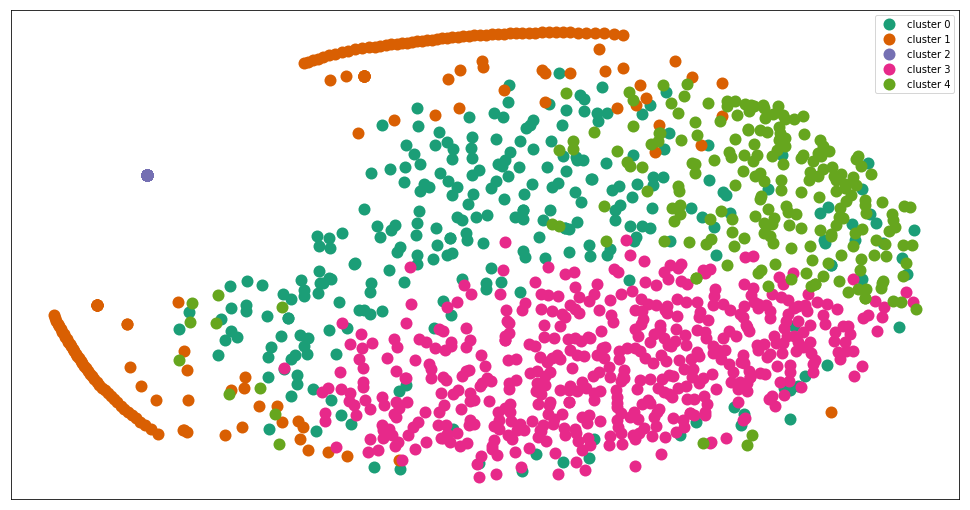

In [11]:
#MDS Scaling
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'cluster 0', 
                 1: 'cluster 1', 
                 2: 'cluster 2', 
                 3: 'cluster 3', 
                 4: 'cluster 4'}
                 
#some ipython magic to show the matplotlib plots inline
#%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
plotdf = pd.DataFrame(dict(x=xs, y=ys, label=newsdf['cluster'])) 
print(len(plotdf))

#group by cluster
groups = plotdf.groupby('label')

%matplotlib inline  
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point
      
plt.show() #show the plot
#plt.savefig("mds.png")
## whats up with the green?? Need to clean up some words 

## Here we use a random forest classifier to associate words in the articles with content

In [13]:

from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 


newsArray=pd.DataFrame.as_matrix(newsdf)
print(newsArray.shape)
print(newsdf.columns.values)

df_sentiment = pd.get_dummies(newsdf['new_sentiment'])
# Join the dummy variables to the main dataframe
newsdf_merged = pd.concat([newsdf, df_sentiment], axis=1)

print "Training the random forest..."
# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, newsdf_merged["Science"] )
print(type(forest))


(1342, 13)
['ind' 'text' 'title' 'source' 'author' 'date' 'num' 'num2' 'url' 'codes'
 'sentiment' 'new_sentiment' 'cluster']
Training the random forest...
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
